<a href="https://colab.research.google.com/github/akshat2109/HAR/blob/main/HAR_Multimodal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **HUMAN ACTIVITY RECOGNITION**



## Multimodal Method: CNN-RNN

### Installing Libraries and downloading Datasets

In [ ]:
!pip install -q git+https://github.com/tensorflow/docs

In [ ]:
from tensorflow_docs.vis import embed
from tensorflow import keras
from imutils import paths
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os

In [ ]:
!wget -q https://git.io/JGc31 -O ucf101_top5.tar.gz
!tar xf ucf101_top5.tar.gz

In [ ]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")

train_df.sample(10)

Total videos for training: 594
Total videos for testing: 224


,video_name,tag
26,v_CricketShot_g11_c06.avi,CricketShot
320,v_Punch_g20_c01.avi,Punch
484,v_TennisSwing_g09_c02.avi,TennisSwing
343,v_Punch_g23_c06.avi,Punch
315,v_Punch_g19_c03.avi,Punch
34,v_CricketShot_g12_c07.avi,CricketShot
223,v_PlayingCello_g23_c07.avi,PlayingCello
592,v_TennisSwing_g25_c05.avi,TennisSwing
488,v_TennisSwing_g09_c06.avi,TennisSwing
559,v_TennisSwing_g20_c02.avi,TennisSwing


In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 15
MAX_SEQ_LENGTH = 20
NUM_FEATURES = 2048

In [ ]:
def crop_center_square(frame):
        y, x = frame.shape[0:2]
        min_dim = min(y, x)
        start_x = (x // 2) - (min_dim // 2)
        start_y = (y // 2) - (min_dim // 2)
        return frame[start_y : start_y+min_dim, start_x : start_x+min_dim]

def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)

### Extracting Features

In [ ]:
def build_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()

87924736/87910968 [==============================] - 1s 0us/step


In [ ]:
label_processor = keras.layers.StringLookup(num_oov_indices=0, vocabulary=np.unique(train_df["tag"]))
print(label_processor.get_vocabulary())

['CricketShot', 'PlayingCello', 'Punch', 'ShavingBeard', 'TennisSwing']


In [ ]:
train_df["tag"]

0      CricketShot
1      CricketShot
2      CricketShot
3      CricketShot
4      CricketShot
          ...     
589    TennisSwing
590    TennisSwing
591    TennisSwing
592    TennisSwing
593    TennisSwing
Name: tag, Length: 594, dtype: object

In [ ]:
def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()
    labels = df["tag"].values
    labels = label_processor(labels[..., None]).numpy()

    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

  
    for idx, path in enumerate(video_paths):
        frames = load_video(os.path.join(root_dir, path))
        frames = frames[None, ...]

        temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor.predict(
                    batch[None, j, :]
                )
            temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()

    return (frame_features, frame_masks), labels

In [ ]:
train_data, train_labels = prepare_all_videos(train_df, "train")
test_data, test_labels = prepare_all_videos(test_df, "test")

print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")

Frame features in train set: (594, 20, 2048)
Frame masks in train set: (594, 20)


### Sequence Model

In [ ]:
def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    x = keras.layers.GRU(16, return_sequences=True)(
        frame_features_input, mask=mask_input
    )
    x = keras.layers.GRU(8)(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(8, activation="relu")(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return rnn_model

In [ ]:
  def run_experiment():
      filepath = "/tmp/video_classifier"
      checkpoint = keras.callbacks.ModelCheckpoint(
          filepath, save_weights_only=True, save_best_only=True, verbose=1
      )

      seq_model = get_sequence_model()
      history = seq_model.fit(
          [train_data[0], train_data[1]],
          train_labels,
          validation_split=0.3,
          epochs=EPOCHS,
          callbacks=[checkpoint],
      )

      seq_model.load_weights(filepath)
      _, accuracy = seq_model.evaluate([test_data[0], test_data[1]], test_labels)
      print(f"Test accuracy: {round(accuracy * 100, 2)}%")

      return history, seq_model

_, sequence_model = run_experiment()

In [ ]:
_.history

{'accuracy': [0.30843374133110046,
  0.5253012180328369,
  0.6000000238418579,
  0.6289156675338745,
  0.6771084070205688,
  0.7734940052032471,
  0.7710843086242676,
  0.8289156556129456,
  0.908433735370636,
  0.908433735370636,
  0.9373493790626526,
  0.9566265344619751,
  0.9566265344619751,
  0.966265082359314,
  0.9590361714363098,
  0.966265082359314,
  0.9686747193336487,
  0.9638554453849792,
  0.9734939932823181,
  0.9734939932823181,
  0.9710843563079834,
  0.9614458084106445,
  0.9855421781539917,
  0.9734939932823181,
  0.9759036302566528,
  0.9879518151283264,
  0.9734939932823181,
  0.9638554453849792,
  0.9783132672309875,
  0.9734939932823181,
  0.9614458084106445,
  0.9638554453849792,
  0.9855421781539917,
  0.9759036302566528,
  0.9855421781539917,
  0.9710843563079834,
  0.9879518151283264,
  0.9710843563079834,
  0.9710843563079834,
  0.9710843563079834,
  0.983132541179657,
  0.983132541179657,
  0.983132541179657,
  0.966265082359314,
  0.966265082359314,
  0.96

### Plots

In [ ]:
accuracy = _["accuracy"]
itr = np.arange(1,16,1)

In [ ]:
plt.xlabel("iterations")
plt.ylabel("accuracy")
plt.title("human activity recognition")
plt.plot(itr, accuracy)
plt.show()

In [ ]:
val_accuracy = _["val_accuracy"]
plt.xlabel("iterations")
plt.ylabel("val_ accuracy")
plt.title("human activity recognition")
plt.plot(itr, val_accuracy)
plt.show()

In [ ]:
loss = _["loss"]
plt.xlabel("iterations")
plt.ylabel("loss")
plt.title("human activity recognition")
plt.plot(itr, loss)
plt.show()

In [ ]:
val_loss = _["val_loss"]
plt.xlabel("iterations")
plt.ylabel("val_loss")
plt.title("human activity recognition")
plt.plot(itr, val_loss)
plt.show()

### Getting Inference

In [ ]:
def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
        frame_mask[i, :length] = 1

    return frame_features, frame_mask


def sequence_prediction(path):
    class_vocab = label_processor.get_vocabulary()

    frames = load_video(os.path.join("test", path))
    frame_features, frame_mask = prepare_single_video(frames)
    probabilities = sequence_model.predict([frame_features, frame_mask])[0]

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    return frames

### Visualization

Test video path: v_ShavingBeard_g03_c05.avi
  CricketShot: 23.26%
  Punch: 21.66%
  TennisSwing: 19.95%
  ShavingBeard: 18.27%
  PlayingCello: 16.85%



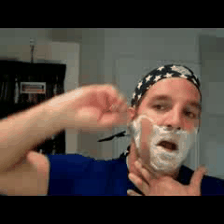

In [ ]:
def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=10)
    return embed.embed_file("animation.gif")

test_video = np.random.choice(test_df["video_name"].values.tolist())
print(f"Test video path: {test_video}")
test_frames = sequence_prediction(test_video)
to_gif(test_frames[:MAX_SEQ_LENGTH])